C:\Users\honli\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


The whole dataset


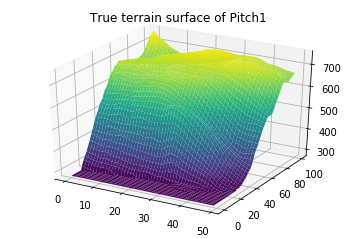

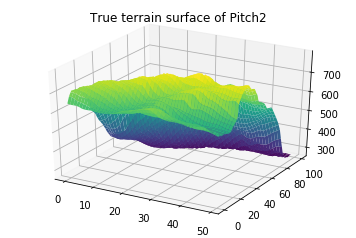

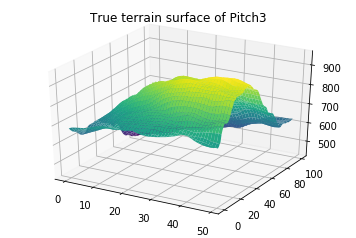

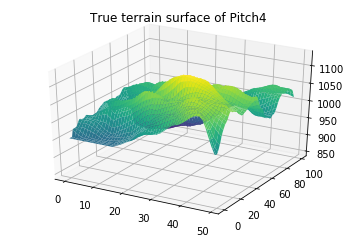

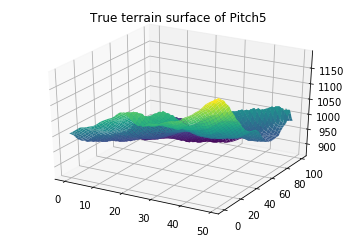

done


In [7]:
import numpy as np
from imageio import imread
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

from sklearn import linear_model

def surface_plot(surface,title, surface1=None):
    M,N = surface.shape

    ax_rows = np.arange(M)
    ax_cols = np.arange(N)

    [X,Y] = np.meshgrid(ax_cols, ax_rows)

    fig = plt.figure()
    if surface1 is not None:
        ax = fig.add_subplot(1,2,1,projection='3d')
        ax.plot_surface(X,Y,surface,cmap=cm.viridis,linewidth=0)
        plt.title(title)

        ax = fig.add_subplot(1,2,2,projection='3d')
        ax.plot_surface(X,Y,surface1,cmap=cm.viridis,linewidth=0)
        plt.title(title)
    else:
        ax = fig.gca(projection='3d')
        ax.plot_surface(X,Y,surface,cmap=cm.viridis,linewidth=0)
        plt.title(title)


def predict(rows, cols, beta):
    out = np.zeros((np.size(rows), np.size(cols)))

    for i,y_ in enumerate(rows):
        for j,x_ in enumerate(cols):
            data_vec = np.array([1, x_, y_, x_**2, x_*y_, y_**2, \
                                x_**3, x_**2*y_, x_*y_**2, y_**3, \
                                x_**4, x_**3*y_, x_**2*y_**2, x_*y_**3,y_**4, \
                                x_**5, x_**4*y_, x_**3*y_**2, x_**2*y_**3,x_*y_**4,y_**5])#,\
            out[i,j] = data_vec @ beta

    return out

def prepare_data(rows, cols):
    for i,y_ in enumerate(rows):
        for j,x_ in enumerate(cols):
            data_vec = np.array([1, x_, y_, x_**2, x_*y_, y_**2, \
                                x_**3, x_**2*y_, x_*y_**2, y_**3, \
                                x_**4, x_**3*y_, x_**2*y_**2, x_*y_**3,y_**4, \
                                x_**5, x_**4*y_, x_**3*y_**2, x_**2*y_**3,x_*y_**4,y_**5])#,\
            out[i,j] = data_vec @ beta

    return data_vec

from sklearn.metrics import mean_squared_error

if __name__ == '__main__':
    # open result files
    text_file = open("real_dataLasso.txt", "w+")
    text_file.write("pitch; alpha; mse; R2; var; bias \n")
    text_re_file = open("real_dataLasso_p.txt", "w+")
    text_re_file.write("pitch; ori; pre \n")
    
    alpha_array = [10.0 ** (-20)]
    max_iter=10000
    min_tol=0.0001
    # Load the terrain
    ori_terrain = imread('SRTM_data_Norway_1.tif')
    [n,m] = ori_terrain.shape

    ## Find some random patches within the dataset and perform a fit

    patch_size_row = 100
    patch_size_col = 50

    # Define their axes
    rows = np.linspace(0,1,patch_size_row)
    cols = np.linspace(0,1,patch_size_col)

    [C,R] = np.meshgrid(cols,rows)

    x = C.reshape(-1,1)
    y = R.reshape(-1,1)

    num_data = patch_size_row*patch_size_col

    # Find the start indices of each patch

    num_patches = 5

    np.random.seed(4155)

    row_starts = np.random.randint(0,n-patch_size_row,num_patches)
    col_starts = np.random.randint(0,m-patch_size_col,num_patches)

    for i,row_start, col_start in zip(np.arange(num_patches),row_starts, col_starts):
        row_end = row_start + patch_size_row
        col_end = col_start + patch_size_col

        patch = ori_terrain[row_start:row_end, col_start:col_end]

        z = patch.reshape(-1,1)

        # Perform OLS fit
        data = np.c_[np.ones((num_data,1)), x, y, \
                     x**2, x*y, y**2, \
                     x**3, x**2*y, x*y**2, y**3, \
                     x**4, x**3*y, x**2*y**2, x*y**3,y**4, \
                     x**5, x**4*y, x**3*y**2, x**2*y**3,x*y**4, y**5]#, \
        for alpha in alpha_array:                
            lasso=linear_model.Lasso(alpha=alpha, fit_intercept=True, normalize=True, precompute=True, copy_X=True, max_iter = max_iter, tol=min_tol, warm_start=False, positive=False, random_state=None)
            lasso.fit(data, z)
            fitted_patch = lasso.predict(data)
            fitted_patch = np.reshape(fitted_patch, ((patch.shape)))           

            mse = np.sum( (fitted_patch - patch)**2 )/num_data
            R2 = 1 - np.sum( (fitted_patch - patch)**2 )/np.sum( (patch - np.mean(patch))**2 )
            var = np.sum( (fitted_patch - np.mean(fitted_patch))**2 )/num_data
            bias = np.sum( (patch - np.mean(fitted_patch))**2 )/num_data

            text_file.write("%d; %.2e; %.4f; %.4f; %.4f; %.4f \n" % (i+1, alpha, mse, R2, var, bias)) 
            surface_plot(patch,'True terrain surface of Pitch' + str(i + 1))
        
            ori = patch.reshape(-1,1)
            predicted = fitted_patch.reshape(-1,1)
            for ip in range(len(ori)):
                ori_value = ori[ip]
                pre_value = predicted[ip]
                text_re_file.write("%d; %.4f; %.4f \n" %(i + 1, ori_value, pre_value))

        
    # Perform fit over the whole dataset
    print("The whole dataset")

    rows = np.linspace(0,1,n)
    cols = np.linspace(0,1,m)

    [C,R] = np.meshgrid(cols,rows)

    x = C.reshape(-1,1)
    y = R.reshape(-1,1)

    num_data = n*m

    data = np.c_[np.ones((num_data,1)), x, y, \
                 x**2, x*y, y**2, \
                 x**3, x**2*y, x*y**2, y**3, \
                 x**4, x**3*y, x**2*y**2, x*y**3,y**4, \
                 x**5, x**4*y, x**3*y**2, x**2*y**3,x*y**4, y**5]

    z = ori_terrain.flatten()
    for alpha in alpha_array:
        lasso=linear_model.Lasso(alpha=alpha, fit_intercept=True, normalize=True, precompute=True, copy_X=True, max_iter = max_iter, tol=min_tol, warm_start=False, positive=False, random_state=None)
        lasso.fit(data, z)
        fitted_terrain = lasso.predict(data)
        fitted_terrain = np.reshape(fitted_terrain, ((ori_terrain.shape)))           

        mse = np.sum( (fitted_terrain - ori_terrain)**2 )/num_data
        R2 = 1 - np.sum( (fitted_terrain - ori_terrain)**2 )/np.sum( (ori_terrain- np.mean(ori_terrain))**2 )
        var = np.sum( (fitted_terrain - np.mean(fitted_terrain))**2 )/num_data
        bias = np.sum( (ori_terrain - np.mean(fitted_terrain))**2 )/num_data

        text_file.write("%d; %.2e; %.4f; %.4f; %.4f; %.4f \n" % (i+1, alpha, mse, R2, var, bias))
    
    text_file.close()
    ori = ori_terrain.reshape(-1,1)
    predicted = fitted_terrain.reshape(-1,1)
    for ip in range(len(ori)):
        ori_value = ori[ip]
        pre_value = predicted[ip]
        text_re_file.write("%d; %.4f; %.4f \n" % (i + 1, ori_value, pre_value))
        
    text_re_file.close()

    plt.show()
    print("done")